#Music Genre Classification:

**Dataset**: https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

###Prepare a dataset:
 - extract the inputs and the target from the music dataset, like labels and mfcc's,
 - store that in a json file to use it later on in the neural network.
 - You could normalize the mfcc's if there are very large.

In [ ]:
import librosa
import os
import math
import json

In [ ]:
DATASET_PATH = "Data/genres_original"
JSON_PATH = "data.json"
SAMPLE_RATE = 22050  # in hertz
DURATION = 30 #seconds
SAMPLES_PER_TRACK = SAMPLE_RATE*DURATION

In [ ]:
def save_mfcc(dataset_path, json_path, n_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
  # num_segments is used to train the machine learning model since we have less data.
  # json_path is where we will be saving all the labels for the sound track.
  # hop_length is used for librosa, which tells by how much interval we should go to the next frame.
  # n_fft = # of intervals we want in one Fast Fourier Transform.

  #Steps: 

  # 1. Build Dictionary to store the data.
  data = {
      "mapping": [],                          # mapping different genre labels to numbers.
      "mfcc": [],                             # mfcc's are the training inputs
      "labels": []                            # labels are the target/outputs of the ML model.
      # Classical is 0, blues is 1.
  }
  num_samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
  expected_num_mfcc_vectors_per_segment = math.ceil(num_samples_per_segment / hop_length)

  # 2. Loop through all the genres folders and analyze all the songs.
  for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
    
    # ensure that we are not at the root level
    if dirpath is not dataset_path:
      #save semantic label in mapping
      dirpath_components = dirpath.split("/")  #genre/blues => [genre, blues]
      semantic_label = dirpath_components[-1]  # -1 means last index
      data["mapping"].append(semantic_label)
      print("\nProcessing {}".format(semantic_label))

      # process files for a specific genre:
      for f in filenames:
        file_path = os.path.join(dirpath, f) # load the audio file here.
        signal, sr = librosa.load(file_path, sr=SAMPLE_RATE)

        # Process segments to extract mfcc and store them.
        for s in range(num_segments):
          start_sample = num_samples_per_segment * s # s is the current segment.
          # for s = 0, start sample = 0, finish sample = 0 + # samples per segment.
          finish_sample = start_sample + num_samples_per_segment
          # These two variables are used to analyze just a slice of the signal.

          mfcc = librosa.feature.mfcc(signal[start_sample:finish_sample], 
                                      sr=sr, 
                                      n_mfcc=n_mfcc,
                                      n_fft=n_fft,
                                      hop_length=hop_length)
          
          mfcc = mfcc.T
          
          # store mfcc for segment if it has expected length:
          if len(mfcc) == expected_num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())   
            # to save it as a json file, cast mfcc(numpy array) to a list.
            data["labels"].append(i - 1)
            print("{}, segment: {}".format(file_path, s))
  with open(json_path, "w") as fp:
    json.dump(data, fp, indent=4)


In [ ]:
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

###Neural Network for Multiclass classification:

In [ ]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

####**Load the data:**
- You can upload the data.json file directly and use it next time

In [ ]:
def load_data(dataset_path):
  with open(dataset_path, "r") as fp:
    data = json.load(fp)
  # convert list into numpy arrays
  inputs = np.array(data["mfcc"])
  targets = np.array(data["labels"])

  return inputs, targets

In [ ]:
inputs, targets = load_data("data.json")
print(inputs.shape)
print(targets.shape)

(9986, 130, 13)
(9986,)


In [ ]:
print(inputs[0][0])

[-59.85346985  91.09191895   8.5219698   44.98475266  -2.88676095
  36.67208099 -13.05821609  17.09495735 -12.34591484   4.52206421
 -12.92686462   8.2150259   -2.40410709]


**Scaling/transforming the data:**

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
# create a dataframe for inputs and target
inputs_copy = inputs.copy()
df_inputs = pd.DataFrame(inputs_copy)
df_targets = pd.DataFrame(targets)

# create an abs_scaler object
abs_scaler = MaxAbsScaler()

# calculate the maximum absolute value for scaling the data using the fit method
abs_scaler.fit(df_inputs)

# the maximum absolute values calculated by the fit method
abs_scaler.max_abs_
# array([4.0e+05, 1.7e+01])

# transform the data using the parameters calculated by the fit method (the maximum absolute values)
scaled_data = abs_scaler.transform(df_inputs)

# store the results in a data frame
df_scaled_input = pd.DataFrame(scaled_data, columns=df_inputs.columns)

# visualize the data frame
df_scaled_input


**Split the data into training and test:**

In [ ]:
Xtr, Xts, ytr, yts = train_test_split(inputs, targets, test_size=0.3)

**Build the network architecture:**

**Rectified Linear Unit(ReLU):** 
 - an activation function used in a keras neural network.
 - Has a better convergence than a Sigmoid function
 - Reduced probability of vanishing gradient.
 - when compared to the sigmoid, it enabled us to train the model way faster.

In [ ]:
model = keras.Sequential([
    # input layer: Flatten takes a multidimension array and flattens it out.
    # 1st dim = incibels, 2nd dim = values for MFCC (13 mfcc's will be extracted.)
    # index 0 represent different segments.
          keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

    # hidden layer 1: 
    #1st par = 512 neurons, relu = Rectified Linear Unit or ReLU
          keras.layers.Dense(512, activation="relu"),
    # hidden layer 2: 
    #1st par = 512 neurons, relu = Rectified Linear Unit or ReLU
          keras.layers.Dense(256, activation="relu"),
    # hidden layer 3: 
    #1st par = 512 neurons, relu = Rectified Linear Unit or ReLU
          keras.layers.Dense(64, activation="relu"),
    # output layer:
          keras.layers.Dense(10, activation="softmax")
    # since we have 10 labels, we're putting 10 here. 
    # we then pick the neuron which has the highest value
    # This neuron will represent the category we are trying to predict.

])

**Compile the network:**
- using the *adam* optimizer is a variation of the classic gradient descent.
- is very effective while used with deep learning.
- we are using the "*sparse_categorical_crossentropy*" as our loss function because this is a multiclass classification problem.

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1)
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 1690)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               865792    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

**Train the network:**

**Types of batching:**
- *Stochastic:*
    - calculate gradient on 1 sample.
    - quick, but inaccurate.
    - eg: batch_size = 1
- *Full batch:*
    - Compute Gradient on the whole training set
    - Slow, memory intensive but accurate
- *Mini Batch:*
    - Compute data on a subset of data set(16-128 samples can be choosen)
    - best of the above.


In [ ]:
history = model.fit(Xtr, ytr, 
          validation_data=(Xts, yts),
          epochs=50,
          batch_size=128)

In [ ]:
def plot_history(history):
  # build subplots for error and accuracy.
  fig, axis = plt.subplots(2)

  # create accuracy subplot
  axis[0].plot(history.history["accuracy"], label="train accuracy")
  axis[0].plot(history.history["val_accuracy"], label="test accuracy")
  axis[0].set_ylabel("Accuracy")
  axis[0].legend(loc="lower right")
  axis[0].set_title("Accuracy evaluation")

  # create error subplot
  axis[1].plot(history.history["loss"], label="train error")
  axis[1].plot(history.history["val_loss"], label="test error")
  axis[1].set_ylabel("Error")
  axis[1].set_xlabel("Epochs")
  axis[1].legend(loc="upper right")
  axis[1].set_title("Error evaluation")

  plt.show()


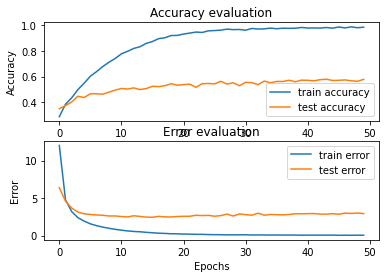

In [ ]:
plot_history(history)

###Solving overfitting:

####**To solve overfitting:**
 - Simpler architecture
    - remove some layers
    - Decrease # neurons in each layer
    - just hit and trail methods
 - Audio Data Augmentation
    - Artificially increase # of training samples
    - apply transformations to audio files as: 
        - pitch shifting
        - time stretching
        - adding background noise
 - Early stopping: 
    - choose rules to stop the training.
    - Eg: after 7 iterations, if error does not decrease, stop the training. 
    - how many epochs to wait before stopping.
 - Dropout:
  - randomly drop neurons while training.
  - this increases network robustness.
  - Dropout probability: 0.1 - 0.5 (has a 10 - 50% of dropping neurons in different layers.)
  - performed dropout in the hidden layers above.
 - Regularization:
  - Add penalty to error function 
  - Punish Large weights
  - L1 regularization
    - L1: minimize abs of the weights.
    - robust to outliers
    - lambda is the regularization hyper parameter we can tweak.
    - generates simpler models.
  - L2 regularization: 
    - minimizes squared value of weights
    - not robust to outliers
    - But it learns complex patterns
    - doing L2 regularization above.

*NOTE:* Use L2 regularization in music and speech.

In [ ]:
model = keras.Sequential([
    # input layer: Flatten takes a multidimension array and flattens it out.
    # 1st dim = incibels, 2nd dim = values for MFCC (13 mfcc's will be extracted.)
    # index 0 represent different segments.
          keras.layers.Flatten(input_shape=(inputs.shape[1], inputs.shape[2])),

    # hidden layer 1: 
    #1st par = 512 neurons, relu = Rectified Linear Unit or ReLU
          keras.layers.Dense(512, activation="relu"),
          keras.layers.Dropout(rate=0.3),
    # hidden layer 2: 
    #1st par = 512 neurons, relu = Rectified Linear Unit or ReLU
          keras.layers.Dense(256, activation="relu"),
          keras.layers.Dropout(rate=0.3),
    # hidden layer 3: 
    #1st par = 512 neurons, relu = Rectified Linear Unit or ReLU
          keras.layers.Dense(64, activation="relu"),
          keras.layers.Dropout(rate=0.3),
    # output layer:
          keras.layers.Dense(10, activation="softmax")
          
    # since we have 10 labels, we're putting 10 here. 
    # we then pick the neuron which has the highest value
    # This neuron will represent the category we are trying to predict.

])

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1)
model.compile(optimizer=optimizer, 
              loss="sparse_categorical_crossentropy", 
              metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 1690)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               865792    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [ ]:
history = model.fit(Xtr, ytr, 
          validation_data=(Xts, yts),
          epochs=50,
          batch_size=128)

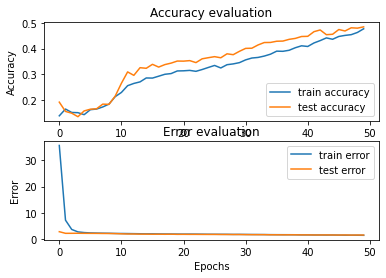

In [ ]:
plot_history(history)

In [ ]:
model.predict(Xts, yts)

**Saving the model in pickle file finally:**

In [ ]:
from keras.models import load_model

model.save('model_audio_final_neural.h5')
print("Saved model successfully")

Saved model successfully


In [ ]:
# filename = 'model_audio_final_neural.pkl'
# pickle.dump(model, open(filename, 'wb'))
# keras.models.save_model(model=model, filepath="/model", overwrite=True)

In [ ]:
from google.colab import files
files.download('model_audio_final_neural.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###**Implementing a CNN for music Genre classification:**

####**Creating train and test validation sets:**

In [ ]:
def prepare_datasets(test_size=0.3, validation_size=0.2):
  # Load data  -> use the load function created above.
  X, y = load_data("data.json")

  # Create the train test split
  Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=test_size)

  # create train validation split. -> Each sample is of shape: (130# time bins, 13#mfccs)
  Xtr, Xval, ytr, yval = train_test_split(Xtr, ytr, test_size=validation_size)

  # Tensorflow's CNN expects a 3D(2D + channel) array for each sample, but our sample is of 2D.
  # adding extra dimesions.
  Xtr = Xtr[..., np.newaxis]   # 4D Array now -> (#samples, 130, 13, 1)
  Xval = Xval[..., np.newaxis]
  Xts = Xts[..., np.newaxis]

  return Xtr, Xval, Xts, ytr, yval, yts


In [ ]:
Xtr, Xval, Xts, ytr, yval, yts = prepare_datasets(test_size=0.25, validation_size=0.2)

####**Build the CNN Network:**

In [ ]:
import tensorflow.keras as keras

In [ ]:
def build_model(input_shape):
  # Create a CNN model: with 3 CNN layers with a max pooling layer.
  model = keras.Sequential()

  # 1st conv Layer
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))  # Max pooling layer.
  model.add(keras.layers.BatchNormalization())  
  # Batch normaliztion complicated math process that normalizes activations in current and subsequent layers. 
  # Speeds ups training a lot faster by converging faster.

  # 2nd Conv Layer
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D(pool_size=(3, 3), strides=(2, 2), padding='same'))  # Max pooling layer.
  model.add(keras.layers.BatchNormalization())

  # 3rd Conv Layer
  model.add(keras.layers.Conv2D(filters=32, kernel_size=(2, 2), activation='relu', input_shape=input_shape))
  model.add(keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), padding='same'))  # Max pooling layer.
  model.add(keras.layers.BatchNormalization())

  # Flatten output and feed in dense layer
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(units=64, activation='relu'))
  model.add(keras.layers.Dropout(rate=0.3))    # to avoid overfitting, use dropout layer

  # Output layer that uses softmax
  model.add(keras.layers.Dense(units=10, activation='softmax')) 
  # Take index with highest value and map that to a corresponding genre.

  return model

In [ ]:
input_shape = (Xtr.shape[1], Xtr.shape[2], Xtr.shape[3])   # tuple
model = build_model(input_shape)

####**Compile the network:**

In [ ]:
optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

####**Train the CNN:**

In [ ]:
history = model.fit(Xtr, ytr, validation_data=(Xval, yval), batch_size=32, epochs=30, verbose=1)

####**Evaluate CNN on test set:**

In [ ]:
test_error, test_accuracy = model.evaluate(Xts, yts)
print("Accuracy on test set is: ", test_accuracy)
print("Error is: ", test_error)

79/79 [==============================] - 0s 2ms/step - loss: 0.8106 - accuracy: 0.7217
Accuracy on test set is:  0.7216659784317017
Error is:  0.8105977773666382


####**Make prediction on a sample:**

_Prediction_ is a 2D array and we have 10 values representing different scores for 10 genres.

We can get the index and then map it to a corresponding genre.

In [ ]:
def predict(model, X, y):
  mapping = np.array(['disco', 'reggae', 'rock', 'pop', 'blues', 'country', 'jazz', 'classical', 'metal', 'hiphop'])
  X = X[np.newaxis, ...] # copy new axis in front
  prediction = model.predict(X)   
  # X is a 3D Array (130, 13, 1), but model.predict expects 4D array of (1 #batch to predict, 130, 13, 1)
  
  # Get index where we have max value
  predicted_index = np.argmax(prediction, axis=1)   # 1D array, where value = 0->9
  print("Expected genre: {} and predicted genre is: {}".format(mapping[y], mapping[predicted_index[0]]))


In [ ]:
X = Xts[101]   # take sample at index 100
y = yts[101]   # do the same for y
predict(model, X, y)

Expected genre: jazz and predicted genre is: jazz


In [ ]:
# for i in range(0, Xts.shape[0]):
#   X = Xts[i]
#   y = yts[i]
#   predict(model, X, y)

####**Saving the model:**

In [ ]:
model.save("trained_CNN_model")
print("Model Saved successfully")

INFO:tensorflow:Assets written to: trained_CNN_model/assets
Model Saved successfully


In [ ]:
# Zipping the folder to download this
from google.colab import files
!zip -r ./trained_CNN_model.zip ./trained_CNN_model/
print("Zip file created.. Downloading the folder now...")
files.download('trained_CNN_model.zip')

updating: trained_CNN_model/ (stored 0%)
updating: trained_CNN_model/variables/ (stored 0%)
updating: trained_CNN_model/variables/variables.data-00000-of-00001 (deflated 10%)
updating: trained_CNN_model/variables/variables.index (deflated 71%)
updating: trained_CNN_model/assets/ (stored 0%)
updating: trained_CNN_model/saved_model.pb (deflated 90%)
Zip file created.. Downloading the folder now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

####**Loading the model back:**

In [ ]:
reconstructed_model = keras.models.load_model("trained_CNN_model")
print("Model loaded successfully...")

Model loaded successfully...
